In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, maskoceans
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
import copy

In [2]:
nlon = 180
nlat = 90
grid_area = np.ones((nlat, nlon))*-9999.
earth_area =  5.096e14;
lat = np.arange(-89, 91, 2)
res = 2;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

In [4]:
############################################################
### Diagnosis of transient case
############################################################

## Inputs from user
## Some constants
yr_beg = 1
nyr = 80

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in = 'fates.ad_spinup.elm.h0.0001_0080.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

## define the sizes of each dimension
ntim = len(time)

## read in variables
soilc = fin.variables['SOILC'][:]
vegc = fin.variables['FATES_VEGC'][:]
vegc_pf = fin.variables['FATES_VEGC_PF'][:]
litterc = fin.variables['LITTERC'][:]

fin.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
lat_4x5 = latnc
lon_4x5 = lonnc


C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


### Biomass change, a site case

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Text(0,0.5,'C density, kgC m-2')

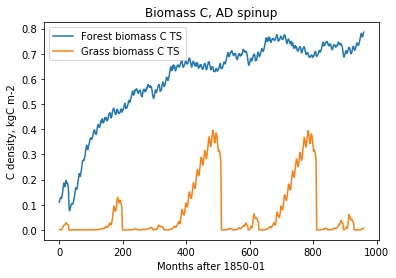

In [25]:
# Get the latitudinal mean of the forest biomass of all datasets
lat_id = 30
lon_id = 50
vegc_pf_copy = copy.deepcopy(vegc_pf)
vegc_pf_copy[vegc_pf_copy>1e2] = np.float('nan')
vegc_pf_copy[vegc_pf_copy<0] = np.float('nan')
vegc_fates_for_ts = np.sum(vegc_pf_copy[:,0:9,lat_id,lon_id], 1)
vegc_fates_gra_ts = np.sum(vegc_pf_copy[:,9:12,lat_id,lon_id], 1)

# plot
plt.plot(vegc_fates_for_ts)
plt.plot(vegc_fates_gra_ts)
plt.legend(['Forest biomass C TS', 'Grass biomass C TS'])
plt.title('Biomass C, AD spinup')
plt.xlabel('Months after 1850-01')
plt.ylabel('C density, kgC m-2')

### Global Veg and Soil C pools

In [6]:
# Calculate global total
# Check the whole time series 

soilc_copy = copy.deepcopy(soilc[:,:,:])
vegc_copy = copy.deepcopy(vegc[:,:,:])
litterc_copy = copy.deepcopy(litterc[:,:,:])

tot_len = nyr * 12
tot_soilc = np.zeros((tot_len))
tot_vegc = np.zeros((tot_len))
tot_litterc = np.zeros((tot_len))

for i in np.arange(0, tot_len):
    # Mask can only applied to each 2D slice
    tmp = soilc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_soilc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

    tmp = vegc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_vegc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e12
    
    tmp = litterc_copy[i,:,:]
    tmp[land_4x5<=0] = np.float('nan')
    tmp[tmp>1e10] = np.float('nan')
    tot_litterc[i] = np.nansum(np.nansum(tmp[:,:]*area_4x5, 0), 0)*1e6/1e15

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


Text(0,0.5,'C Pools (PgC)')

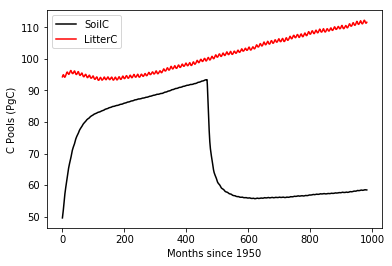

In [9]:
plt.plot(tot_soilc, 'k-')
# plt.plot(tot_vegc, 'g-')
plt.plot(tot_litterc, 'r-')
plt.legend(['SoilC', 'LitterC'])
plt.xlabel('Months since 1950')
plt.ylabel('C Pools (PgC)')

Text(0,0.5,'C Fluxes (PgC yr-1)')

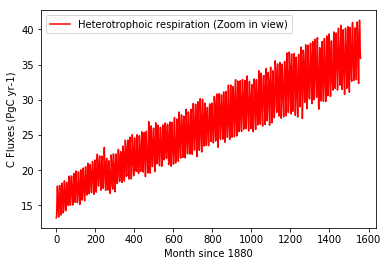

In [66]:
plt.plot(tot_fates_hr, 'r-')
plt.legend(['Heterotrophoic respiration (Zoom in view)'])
plt.xlabel('Month since 1880')
plt.ylabel('C Fluxes (PgC yr-1)')

Text(0,0.5,'C Pools (PgC )')

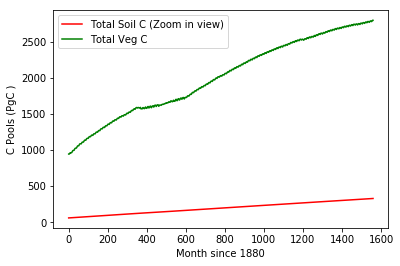

In [79]:
plt.plot(tot_soilc, 'r-')
plt.plot(tot_vegc, 'g-')
plt.legend(['Total Soil C (Zoom in view)', 'Total Veg C'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')

Text(0,0.5,'C Pools (PgC )')

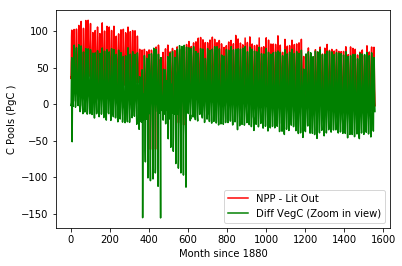

In [81]:
veg_old = tot_vegc[0:tot_len-1]
veg_new = tot_vegc[1:tot_len]
diff_veg = veg_new - veg_old
plt.plot(tot_fates_npp-tot_lit_out, 'r-')
plt.plot(diff_veg*12, 'g-')
plt.legend(['NPP - Lit Out', 'Diff VegC'])
plt.xlabel('Month since 1880')
plt.ylabel('C Pools (PgC )')